In [1]:
import pandas as pd
import numpy as np
import json
import csv
#1.确定这几个数据都是干什么的
swiping_card_dataframe = pd.read_csv('./bus_swiping_card_info1.csv')
card_info_dataframe = pd.read_csv('./card_info.csv')
bus_swip_dataframe = pd.read_excel('公交数据.xlsx',sheet_name='刷卡数据',header=0,engine='openpyxl')
bus_station_dataframe = pd.read_excel('公交数据.xlsx',sheet_name='站点数据',header=0,engine='openpyxl')
#swiping_card_dataframe ： 每次刷卡的信息：几号线，第几站，车辆的id，刷卡的id，刷卡的时间
#card_info_dataframe ： 每次刷卡的信息：几号线，第几站，车辆的id，刷卡的id，刷卡的时间也是上面的信息，但是时间是去年的。
#用去年的时间的同比数据，去预测今年的同比数据，看是否一致，如果一致，说明经济发展没有变化，如果变大，说明经济好转
#bus_swip_dataframe ：一天的统计信息：各条线路、各个站点的刷卡数量信息
#bus_station_dataframe ： 站点的统计信息：各个站点的经纬度
line_station_number_sequen_dataframe = \
bus_station_dataframe.groupby(['line_identity','station_number']).agg({'station_name':list,'station_identity':list}).reset_index()
line_station_number_sequen_dataframe['length'] = line_station_number_sequen_dataframe['station_identity'].apply(lambda x:len(x))
line_station_number_sequen_dataframe

,line_identity,station_number,station_name,station_identity,length
0,1,20,"[火车站, 展览馆, 新路口, 邮电大楼, 大十字, 喷水池, 云中广场, 六广门, 北京路...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",20
1,2,20,"[火车站, 展览馆, 新路口, 河滨公园, 次南门, 大西门, 紫林庵, 延安西路, 黔灵山...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",20
2,3,29,"[贵州理工学院, 贵黄交警支队, 枫丹白鹭花园, 后坝, 三桥水果市场, 三桥, 三桥北路口...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",29
3,4,44,"[新寨公交枢纽, 南厂路南, 军区干休所, 武岳新村, 军区二招, 南厂路北, 纪念塔, 箭...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",44
4,5,36,"[甘荫塘轨道站, 甘荫塘, 四方河路站, 通银配件城, 皂角井站, 凤凰翠堤, 新发装饰市场...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",36
...,...,...,...,...,...
320,10050,46,"[一八三厂, 毛寨村, 小河平桥, 黄河路南, 黄河路北, 四十四医院, 新村, 四方河, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",46
321,10056,31,"[乐湾国际城, 东风镇, 贵州师范学院, 云上村, 117地质队, 温泉路口, 新添寨, 市...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",31
322,10229,28,"[金阳客站, 商城东路, 宾阳大道, 兴筑西路, 碧海乾图, 黔中一中南, 老阳关, 北京路...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",28
323,10262,24,"[黔中北站, 甲秀北路, 杨家庄, 大关, 鹿冲关公园, 相宝山, 师大, 省公安厅, 宝山...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",24


In [ ]:
line_station_number_sequen_dataframe['id_station'] = \
line_station_number_sequen_dataframe.apply(lambda x:list(zip(x['station_identity'],x['station_name'])),axis=1)
line_station_number_sequen_dataframe
#构建一个字典：
#road_structure = {line_id:{'stations_nums':int,'stations':{station_id:station_name},'all_stations':[]}}
road_line_station_structure_setting={}
for row_index in range(len(line_station_number_sequen_dataframe)):
    line_id = line_station_number_sequen_dataframe[row_index:row_index+1]['line_identity'].values[0]
    stations_nums = line_station_number_sequen_dataframe[row_index:row_index+1]['station_number'].values[0]
    all_stations = line_station_number_sequen_dataframe[row_index:row_index+1]['station_name'].values[0]
    stations={}
    for instance in line_station_number_sequen_dataframe[row_index:row_index+1]['id_station'].values[0]:
        instance_id = instance[0]
        instance_name = instance[1]
        stations[instance_id]=instance_name
    road_line = {'stations_nums':stations_nums,'stations':stations,'all_stations':all_stations}
    road_line_station_structure_setting[line_id] = road_line    
road_line_station_structure_setting  

In [ ]:
#怎么生成客流需求？
#已经知道了各个站点去向各个站点在各个时刻的概率分布。
#各个站点不同时刻去向其他站点的概率分布。
#如果去向各个站点的概率是以小时粒度存在的，
#比如在上午八点的时候，a号线b站的乘客去往其他各站的概率分布为：[0.1,0.2,0.4]
#在上午八点到九点的时候，a号线b站的客流量为300人每小时。
#在上午九点到10点的时候，a号线b站的客流量为400人每小时。

In [ ]:
#将乘客的出行流量更精细一些，达到30分钟的精度。
#我们可以一步一仿真
#从而根据这些识别出每一步旅客的出行情况。
#step函数就把各个站点的出发情况统计出来。


In [ ]:
#站点的属性包括：
#1.各个时刻的客流量
#2.各个时刻旅客路径选择的概率分布。精度为30分钟一组。
#3.公交的出行时间从早上六点到早上

In [12]:
total = []
for i in range(10):
    total.append(np.random.poisson(0.3))
print(total)
#精度也是可以调整的。
#出行的概率应该也是可以调整的。
#但是我的是dataframe，聚类也挺不容易的。
#刷卡数据处理得到各个站点的客流量和出行路径选择的代码为：

[0, 1, 1, 0, 0, 0, 0, 1, 0, 0]


```python
def step():
    1.遍历站点根据客流量服从泊松分布，路径选择服从统计规律。生成乘客到站情况
    2.更新公交车上的位置情况。如果乘客到站时间早于公交车到站时间，则当公交车到站时，自动将乘客加载到公交车上。
    3.统计指标包括：站点的等车人数，路段上的人数。
    4.根据站点等车人数和路段上的人数综合确定公交走廊。
    5.返回公交走廊路段列表。
```

路径A的每分钟分配人数： [1]
路径B的每分钟分配人数： [0]
路径C的每分钟分配人数： [1]


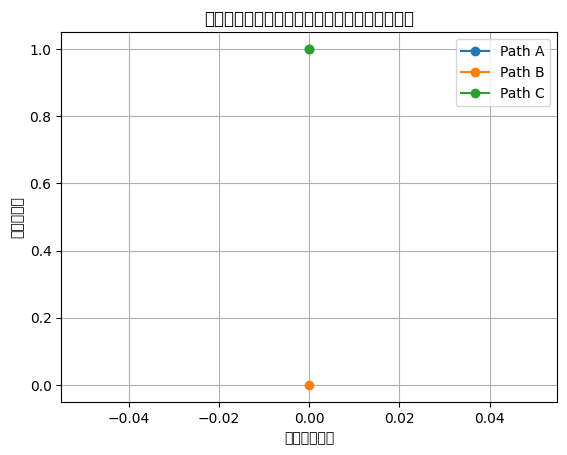

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 每分钟的到达率
lambda_per_minute = 300 / 60  # 每分钟5人

# 模拟60分钟的到达人数
simulated_arrivals = np.random.poisson(lambda_per_minute, 1)

# 路径选择概率分布
path_probabilities = [0.5, 0.3, 0.2]

# 初始化路径分配结果
path_allocations = { "Path_A": [], "Path_B": [], "Path_C": [] }

# 对每分钟的到达人数进行路径分配
for arrivals in simulated_arrivals:
    allocation = np.random.multinomial(arrivals, path_probabilities)
    path_allocations["Path_A"].append(allocation[0])
    path_allocations["Path_B"].append(allocation[1])
    path_allocations["Path_C"].append(allocation[2])

# 打印结果
print("路径A的每分钟分配人数：", path_allocations["Path_A"])
print("路径B的每分钟分配人数：", path_allocations["Path_B"])
print("路径C的每分钟分配人数：", path_allocations["Path_C"])

# 可视化结果
plt.plot(path_allocations["Path_A"], marker='o', label='Path A')
plt.plot(path_allocations["Path_B"], marker='o', label='Path B')
plt.plot(path_allocations["Path_C"], marker='o', label='Path C')
plt.title("上午八点到九点期间每分钟的乘客路径分配模拟")
plt.xlabel("时间（分钟）")
plt.ylabel("乘客到达数")
plt.legend()
plt.grid(True)
plt.show()
